In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from PIL import Image
from tqdm import tqdm

# Set seeds for reproducibility
torch.manual_seed(39)
np.random.seed(39)

# Define dataset paths
FACE_DIR = "/kaggle/input/visa-multimodal/VISA_Face"
IRIS_DIR = "/kaggle/input/visa-multimodal/VISA_Iris/VISA_Iris"


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


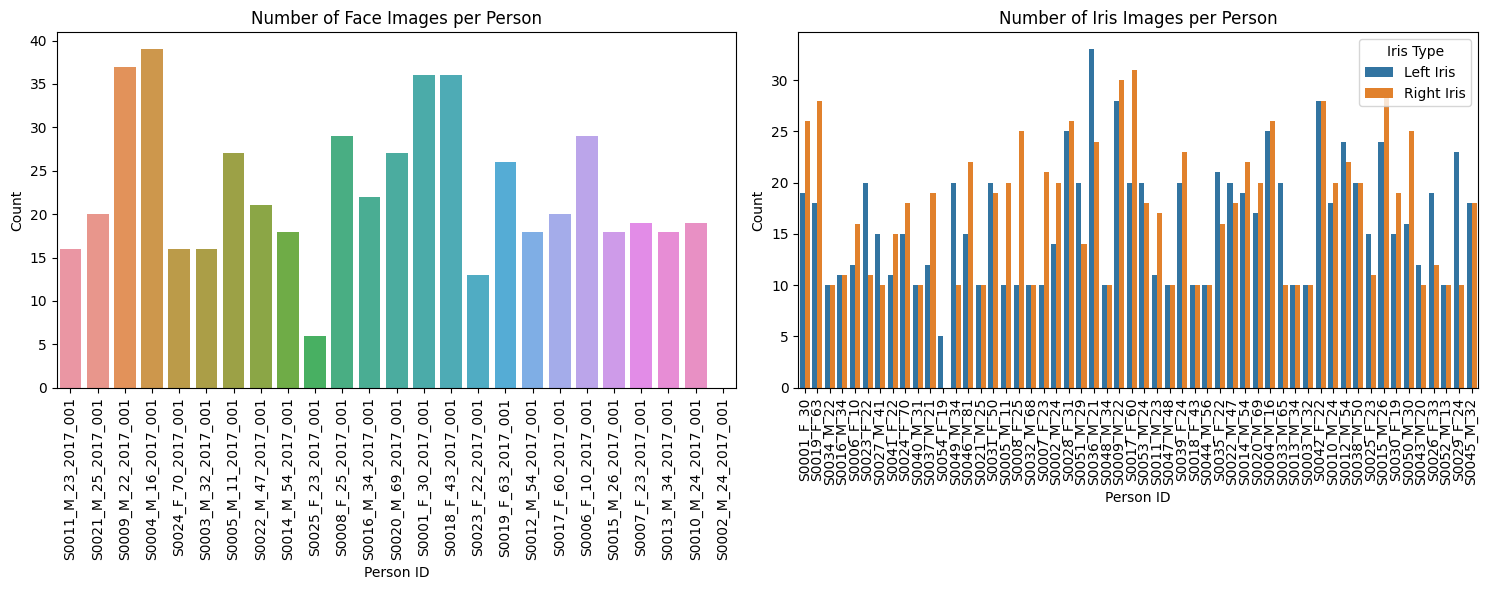

In [2]:
def explore_dataset(face_dir, iris_dir):
    """Explore and visualize the dataset structure"""
    # Count face images per person
    face_counts = {}
    for person in os.listdir(face_dir):
        person_path = os.path.join(face_dir, person)
        if os.path.isdir(person_path):
            face_counts[person] = len([f for f in os.listdir(person_path) if f.endswith('.jpg')])
    
    # Count iris images per person
    iris_counts = {'left': {}, 'right': {}}
    all_persons = set()
    
    # First pass to collect all unique persons
    for person in os.listdir(iris_dir):
        person_path = os.path.join(iris_dir, person)
        if os.path.isdir(person_path):
            all_persons.add(person)
            
    # Second pass to count images
    for person in all_persons:
        person_path = os.path.join(iris_dir, person)
        left_path = os.path.join(person_path, 'L')
        right_path = os.path.join(person_path, 'R')
        
        iris_counts['left'][person] = len([f for f in os.listdir(left_path) if f.endswith('.bmp')]) if os.path.exists(left_path) else 0
        iris_counts['right'][person] = len([f for f in os.listdir(right_path) if f.endswith('.bmp')]) if os.path.exists(right_path) else 0

    # Create aligned data structure
    persons = list(all_persons)
    left_counts = [iris_counts['left'].get(p, 0) for p in persons]
    right_counts = [iris_counts['right'].get(p, 0) for p in persons]

    # Visualize the dataset distribution
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(face_counts.keys()), y=list(face_counts.values()))
    plt.title('Number of Face Images per Person')
    plt.xticks(rotation=90)
    plt.xlabel('Person ID')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    df = pd.DataFrame({
        'Person': persons,
        'Left Iris': left_counts,
        'Right Iris': right_counts
    })
    df_melted = df.melt(id_vars='Person', var_name='Iris Type', value_name='Count')
    sns.barplot(x='Person', y='Count', hue='Iris Type', data=df_melted)
    plt.title('Number of Iris Images per Person')
    plt.xticks(rotation=90)
    plt.xlabel('Person ID')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return face_counts, iris_counts

# Run the exploration
face_counts, iris_counts = explore_dataset(FACE_DIR, IRIS_DIR)


In [3]:
class BiometricDataset(Dataset):
    def __init__(self, face_dir, iris_dir, split='train', test_size=0.15, val_size=0.15, 
                 transform=None, use_both_eyes=True, neg_ratio=1.0):
        self.face_dir = face_dir
        self.iris_dir = iris_dir
        self.transform = transform
        self.split = split
        self.use_both_eyes = use_both_eyes
        self.neg_ratio = neg_ratio  # Ratio of impostor to genuine samples

        self.person_data = {}
        for person in os.listdir(face_dir):
            person_path = os.path.join(face_dir, person)
            if os.path.isdir(person_path):
                person_id = person[:10]
                iris_path = os.path.join(iris_dir, person_id)
                if os.path.exists(iris_path):
                    face_imgs = [os.path.join(person_path, img) for img in os.listdir(person_path) if img.endswith(".jpg")]
                    left_iris = [os.path.join(iris_path, "L", img) for img in os.listdir(os.path.join(iris_path, "L")) if img.endswith(".bmp")] if os.path.exists(os.path.join(iris_path, "L")) else []
                    right_iris = [os.path.join(iris_path, "R", img) for img in os.listdir(os.path.join(iris_path, "R")) if img.endswith(".bmp")] if os.path.exists(os.path.join(iris_path, "R")) else []
                    if face_imgs and (left_iris or right_iris):
                        self.person_data[person_id] = {'face': face_imgs, 'left': left_iris, 'right': right_iris}

        self.pairs = []
        self.labels = []

        person_ids = list(self.person_data.keys())

        # Create genuine pairs
        for pid in person_ids:
            data = self.person_data[pid]
            for face in data['face'][:2]:  # Limit per person to control dataset size
                if data['left']:
                    self.pairs.append((face, data['left'][0], 'left'))
                    self.labels.append(1)
                if self.use_both_eyes and data['right']:
                    self.pairs.append((face, data['right'][0], 'right'))
                    self.labels.append(1)

        # Create impostor pairs based on desired ratio
        num_positive = len(self.labels)
        num_negative = int(num_positive * self.neg_ratio)

        while len([l for l in self.labels if l == 0]) < num_negative:
            pid1, pid2 = np.random.choice(person_ids, 2, replace=False)
            face_imgs = self.person_data[pid1]['face']
            iris_imgs = self.person_data[pid2]['left'] if np.random.rand() < 0.5 else self.person_data[pid2]['right']
            if face_imgs and iris_imgs:
                self.pairs.append((face_imgs[0], iris_imgs[0], 'left' if iris_imgs == self.person_data[pid2]['left'] else 'right'))
                self.labels.append(0)

        # Shuffle pairs and stratified split
        indices = np.arange(len(self.pairs))
        labels_arr = np.array(self.labels)
        train_idx, test_idx = train_test_split(indices, test_size=test_size, stratify=labels_arr, random_state=42)
        if val_size > 0:
            train_idx, val_idx = train_test_split(train_idx, test_size=val_size / (1 - test_size),
                                                  stratify=labels_arr[train_idx], random_state=42)
        else:
            val_idx = []

        self.indices = {'train': train_idx, 'val': val_idx, 'test': test_idx}.get(split, indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        face_path, iris_path, eye_type = self.pairs[idx]
        label = self.labels[idx]

        face_img = Image.open(face_path).convert("RGB")
        iris_img = Image.open(iris_path).convert("L")

        if self.transform:
            face_img = self.transform(face_img)
            iris_img = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])(iris_img)

        return face_img, iris_img, label, eye_type


# Define image transformations
face_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 1:1 ratio of genuine:impostor
train_dataset = BiometricDataset(FACE_DIR, IRIS_DIR, split='train', transform=face_transform, neg_ratio=2.0)
val_dataset = BiometricDataset(FACE_DIR, IRIS_DIR, split='val', transform=face_transform, neg_ratio=2.0)
test_dataset = BiometricDataset(FACE_DIR, IRIS_DIR, split='test', transform=face_transform, neg_ratio=2.0)


# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)


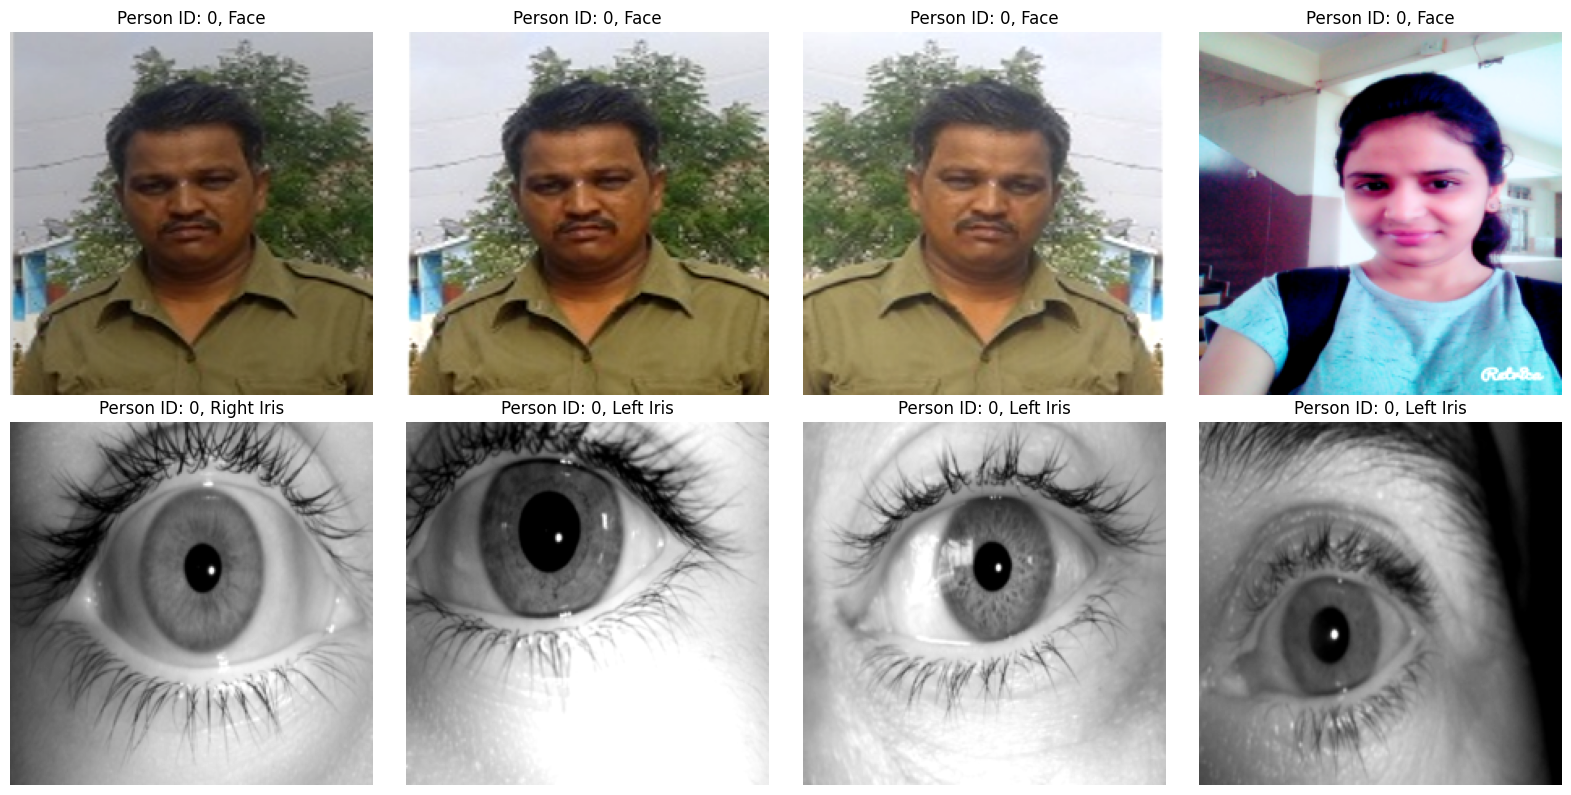

In [4]:
def visualize_batch(dataset, num_samples=4):
    """Visualize sample pairs from the dataset"""
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))
    
    for i in range(num_samples):
        face_img, iris_img, label, eye_type = dataset[i]
        
        # Denormalize images for visualization
        face_img = face_img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        face_img = torch.clamp(face_img, 0, 1)
        
        iris_img = iris_img * 0.5 + 0.5  # Denormalize
        
        # Display images
        axes[0, i].imshow(face_img.permute(1, 2, 0).numpy())
        axes[0, i].set_title(f"Person ID: {label}, Face")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(iris_img.squeeze(0).numpy(), cmap='gray')
        axes[1, i].set_title(f"Person ID: {label}, {eye_type.capitalize()} Iris")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_batch(train_dataset)


In [5]:
class FaceFeatureExtractor(nn.Module):
    """Feature extraction model for face images based on ResNet50"""
    def __init__(self, pretrained=True, feature_dim=512):
        super(FaceFeatureExtractor, self).__init__()
        # Using ResNet50 as base model as mentioned in research papers
        self.base_model = models.resnet50(pretrained=pretrained)
        # Replace the final FC layer
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, feature_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        return self.base_model(x)

class IrisFeatureExtractor(nn.Module):
    """Feature extraction model for iris images based on VGG16"""
    def __init__(self, pretrained=True, feature_dim=512):
        super(IrisFeatureExtractor, self).__init__()
        # Using modified VGG16 for iris as mentioned in some papers
        self.base_model = models.vgg16(pretrained=pretrained)
        # Modify first layer to accept grayscale input
        self.base_model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        # Replace classifier
        self.base_model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, feature_dim)
        )
        
    def forward(self, x):
        return self.base_model(x)


In [6]:
class CrossAttentionFusion(nn.Module):
    """Cross-attention fusion module based on paper [5]"""
    def __init__(self, embed_dim=512, num_heads=8):
        super(CrossAttentionFusion, self).__init__()
        self.face_norm = nn.LayerNorm(embed_dim)
        self.iris_norm = nn.LayerNorm(embed_dim)
        
        # Multi-head attention layers
        self.face_to_iris_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.iris_to_face_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        # Feed-forward networks
        self.face_ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(0.1)
        )
        
        self.iris_ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(0.1)
        )
        
        # Final fusion layer
        self.fusion_layer = nn.Linear(embed_dim * 2, embed_dim)
        
    def forward(self, face_features, iris_features):
        # Reshape tensors to (batch_size, 1, embed_dim) for attention
        batch_size = face_features.size(0)
        face_features = face_features.view(batch_size, 1, -1)
        iris_features = iris_features.view(batch_size, 1, -1)
        
        # Apply layer normalization
        face_norm = self.face_norm(face_features)
        iris_norm = self.iris_norm(iris_features)
        
        # Cross-attention
        face_attended, _ = self.face_to_iris_attention(face_norm, iris_norm, iris_norm)
        iris_attended, _ = self.iris_to_face_attention(iris_norm, face_norm, face_norm)
        
        # Residual connection
        face_residual = face_features + face_attended
        iris_residual = iris_features + iris_attended
        
        # Feed-forward networks
        face_output = face_residual + self.face_ffn(face_residual)
        iris_output = iris_residual + self.iris_ffn(iris_residual)
        
        # Concatenate and fuse
        combined = torch.cat([face_output.squeeze(1), iris_output.squeeze(1)], dim=1)
        fused = self.fusion_layer(combined)
        
        return fused

class ScoreLevelFusion(nn.Module):
    """Score-level fusion with SVM-inspired approach (based on paper [1])"""
    def __init__(self, input_dim=1024, hidden_dim=512, output_dim=256):
        super(ScoreLevelFusion, self).__init__()
        # SVM-inspired layers (using neural network approximation)
        self.fusion_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(output_dim, output_dim),
        )
        
    def forward(self, face_scores, iris_scores):
        # Concatenate the scores from both modalities
        combined_scores = torch.cat([face_scores, iris_scores], dim=1)
        return self.fusion_layer(combined_scores)


In [7]:
class MultimodalBiometricSystem(nn.Module):
    def __init__(self, num_classes, fusion_type='cross_attention', feature_dim=512):
        super(MultimodalBiometricSystem, self).__init__()
        self.fusion_type = fusion_type
        
        # Feature extractors
        self.face_extractor = FaceFeatureExtractor(feature_dim=feature_dim)
        self.iris_extractor = IrisFeatureExtractor(feature_dim=feature_dim)
        
        # Fusion module
        if fusion_type == 'cross_attention':
            self.fusion_module = CrossAttentionFusion(embed_dim=feature_dim)
            self.classifier = nn.Sequential(
                nn.Linear(feature_dim, feature_dim),
                nn.ReLU(),
                nn.Dropout(0.5),  # Dropout added here
                nn.Linear(feature_dim, num_classes)
            )
        elif fusion_type == 'score_level':
            self.face_classifier = nn.Linear(feature_dim, feature_dim)
            self.iris_classifier = nn.Linear(feature_dim, feature_dim)
            self.fusion_module = ScoreLevelFusion(input_dim=feature_dim*2, output_dim=feature_dim)
            self.classifier = nn.Sequential(
                nn.Linear(feature_dim, feature_dim),
                nn.ReLU(),
                nn.Dropout(0.5),  # Dropout added here
                nn.Linear(feature_dim, num_classes)
            )

    def forward(self, face_input, iris_input):
        face_features = self.face_extractor(face_input)
        iris_features = self.iris_extractor(iris_input)

        if self.fusion_type == 'cross_attention':
            fused_features = self.fusion_module(face_features, iris_features)
            output = self.classifier(fused_features)
        elif self.fusion_type == 'score_level':
            face_scores = self.face_classifier(face_features)
            iris_scores = self.iris_classifier(iris_features)
            fused_scores = self.fusion_module(face_scores, iris_scores)
            output = self.classifier(fused_scores)

        return output

    
    def get_face_features(self, face_input):
        return self.face_extractor(face_input)
    
    def get_iris_features(self, iris_input):
        return self.iris_extractor(iris_input)


In [8]:
class FaceOnlyModel(nn.Module):
    """Face recognition only model"""
    def __init__(self, num_classes, feature_dim=512):
        super(FaceOnlyModel, self).__init__()
        self.face_extractor = FaceFeatureExtractor(feature_dim=feature_dim)
        self.classifier = nn.Linear(feature_dim, num_classes)
        
    def forward(self, face_input):
        face_features = self.face_extractor(face_input)
        return self.classifier(face_features)

class IrisOnlyModel(nn.Module):
    """Iris recognition only model"""
    def __init__(self, num_classes, feature_dim=512):
        super(IrisOnlyModel, self).__init__()
        self.iris_extractor = IrisFeatureExtractor(feature_dim=feature_dim)
        self.classifier = nn.Linear(feature_dim, num_classes)
        
    def forward(self, iris_input):
        iris_features = self.iris_extractor(iris_input)
        return self.classifier(iris_features)


In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, 
                num_epochs=25, device='cuda', model_type='multimodal', early_stopping=True):
    model = model.to(device)
    
    best_val_f1 = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'train_f1': [], 'train_precision': [], 'train_recall': [],
        'val_loss': [], 'val_acc': [],
        'val_f1': [], 'val_precision': [], 'val_recall': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}\n{"-"*10}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            all_preds = []
            all_labels = []

            pbar = tqdm(loader, desc=f"{phase.capitalize()} Epoch {epoch+1}/{num_epochs}")

            for inputs in pbar:
                if model_type == 'multimodal':
                    face_inputs, iris_inputs, labels, _ = inputs
                    face_inputs = face_inputs.to(device)
                    iris_inputs = iris_inputs.to(device)
                elif model_type == 'face_only':
                    face_inputs, _, labels, _ = inputs
                    face_inputs = face_inputs.to(device)
                elif model_type == 'iris_only':
                    _, iris_inputs, labels, _ = inputs
                    iris_inputs = iris_inputs.to(device)

                labels = labels.to(device)

                if phase == 'train':
                    optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if model_type == 'multimodal':
                        outputs = model(face_inputs, iris_inputs)
                    elif model_type == 'face_only':
                        outputs = model(face_inputs)
                    elif model_type == 'iris_only':
                        outputs = model(iris_inputs)

                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * labels.size(0)
                running_corrects += torch.sum(preds == labels).item()
                total_samples += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                pbar.set_postfix({'loss': loss.item(), 'acc': running_corrects / total_samples})

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            epoch_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
            epoch_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
            epoch_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            print(f"{phase.capitalize()} F1: {epoch_f1:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}")

            # Save history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_f1'].append(epoch_f1)
            history[f'{phase}_precision'].append(epoch_precision)
            history[f'{phase}_recall'].append(epoch_recall)

            # Save best model
            if phase == 'val' and early_stopping:
                if epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    torch.save(model.state_dict(), f'best_{model_type}_model_f1.pth')

            # Update learning rate
            if scheduler and phase == 'val':
                scheduler.step(epoch_f1 if early_stopping else epoch_acc)

    print(f"Best Validation F1: {best_val_f1:.4f}")
    return history

def evaluate_model(model, test_loader, criterion, device='cuda', model_type='multimodal'):
    """Evaluate the model on the test set"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs in tqdm(test_loader, desc="Evaluating"):
            if model_type == 'multimodal':
                face_inputs, iris_inputs, labels, _ = inputs
                face_inputs = face_inputs.to(device)
                iris_inputs = iris_inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(face_inputs, iris_inputs)
            elif model_type == 'face_only':
                face_inputs, _, labels, _ = inputs
                face_inputs = face_inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(face_inputs)
            elif model_type == 'iris_only':
                _, iris_inputs, labels, _ = inputs
                iris_inputs = iris_inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(iris_inputs)
            
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += labels.size(0)
            
            # Store for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = running_loss / total_samples
    test_acc = running_corrects / total_samples
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    print(f'Classification Report:')
    print(classification_report(all_labels, all_preds))
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'predictions': all_preds,
        'labels': all_labels,
        'confusion_matrix': cm
    }


In [11]:
from sklearn.utils.class_weight import compute_class_weight
def get_class_weights(dataset):
    labels = [dataset.labels[i] for i in dataset.indices]
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    return torch.tensor(class_weights, dtype=torch.float)

# Define hyperparameters
num_classes = 2  # Binary classification (genuine vs impostor)
feature_dim = 512
learning_rate = 1e-4
num_epochs = 25


# Instantiate models
multimodal_model = MultimodalBiometricSystem(num_classes=num_classes, fusion_type='cross_attention', feature_dim=feature_dim)
face_only_model = FaceOnlyModel(num_classes=num_classes, feature_dim=feature_dim)
iris_only_model = IrisOnlyModel(num_classes=num_classes, feature_dim=feature_dim)

# Define loss function and optimizer
class_weights = get_class_weights(train_dataset).to('cpu')
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer_multimodal = optim.Adam(multimodal_model.parameters(), lr=learning_rate)
optimizer_face = optim.Adam(face_only_model.parameters(), lr=learning_rate)
optimizer_iris = optim.Adam(iris_only_model.parameters(), lr=learning_rate)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s] 
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

In [12]:
def plot_training_history(history, title='Training History'):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(18, 12))
    
    # 1. Loss Plot
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Accuracy Plot
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 3. F1 Score Plot
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    # 4. Precision Plot
    plt.subplot(2, 3, 4)
    plt.plot(epochs, history['train_precision'], label='Train Precision')
    plt.plot(epochs, history['val_precision'], label='Val Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # 5. Recall Plot
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history['train_recall'], label='Train Recall')
    plt.plot(epochs, history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    # Overall layout
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Epoch 1/25
----------


Train Epoch 1/25: 100%|██████████| 13/13 [04:39<00:00, 21.47s/it, loss=0.666, acc=0.49] 


Train Loss: 0.7312 Acc: 0.4900
Train F1: 0.4499 Precision: 0.4542 Recall: 0.4502


Val Epoch 1/25: 100%|██████████| 3/3 [00:19<00:00,  6.59s/it, loss=0.737, acc=0.341]


Val Loss: 0.6849 Acc: 0.3409
Val F1: 0.2542 Precision: 0.1705 Recall: 0.5000
Epoch 2/25
----------


Train Epoch 2/25: 100%|██████████| 13/13 [04:37<00:00, 21.31s/it, loss=0.868, acc=0.575]


Train Loss: 0.7026 Acc: 0.5750
Train F1: 0.5523 Precision: 0.5570 Recall: 0.5637


Val Epoch 2/25: 100%|██████████| 3/3 [00:19<00:00,  6.34s/it, loss=0.635, acc=0.636]


Val Loss: 0.6558 Acc: 0.6364
Val F1: 0.5633 Precision: 0.5758 Recall: 0.5632
Epoch 3/25
----------


Train Epoch 3/25: 100%|██████████| 13/13 [04:34<00:00, 21.14s/it, loss=0.699, acc=0.61] 


Train Loss: 0.6627 Acc: 0.6100
Train F1: 0.6068 Precision: 0.6408 Recall: 0.6551


Val Epoch 3/25: 100%|██████████| 3/3 [00:18<00:00,  6.22s/it, loss=0.627, acc=0.727]


Val Loss: 0.7288 Acc: 0.7273
Val F1: 0.5810 Precision: 0.8537 Recall: 0.6000
Epoch 4/25
----------


Train Epoch 4/25: 100%|██████████| 13/13 [04:31<00:00, 20.88s/it, loss=0.494, acc=0.72] 


Train Loss: 0.6159 Acc: 0.7200
Train F1: 0.6600 Precision: 0.6800 Recall: 0.6526


Val Epoch 4/25: 100%|██████████| 3/3 [00:18<00:00,  6.19s/it, loss=0.57, acc=0.636] 


Val Loss: 0.6207 Acc: 0.6364
Val F1: 0.5810 Precision: 0.5856 Recall: 0.5793
Epoch 5/25
----------


Train Epoch 5/25: 100%|██████████| 13/13 [04:32<00:00, 21.00s/it, loss=0.548, acc=0.74] 


Train Loss: 0.5869 Acc: 0.7400
Train F1: 0.7060 Precision: 0.7060 Recall: 0.7060


Val Epoch 5/25: 100%|██████████| 3/3 [00:19<00:00,  6.49s/it, loss=0.573, acc=0.75] 


Val Loss: 0.5035 Acc: 0.7500
Val F1: 0.7061 Precision: 0.7240 Recall: 0.6977
Epoch 6/25
----------


Train Epoch 6/25: 100%|██████████| 13/13 [04:33<00:00, 21.07s/it, loss=0.366, acc=0.75] 


Train Loss: 0.5482 Acc: 0.7500
Train F1: 0.7103 Precision: 0.7167 Recall: 0.7058


Val Epoch 6/25: 100%|██████████| 3/3 [00:19<00:00,  6.50s/it, loss=0.514, acc=0.75] 


Val Loss: 0.5165 Acc: 0.7500
Val F1: 0.7061 Precision: 0.7240 Recall: 0.6977
Epoch 7/25
----------


Train Epoch 7/25: 100%|██████████| 13/13 [04:33<00:00, 21.04s/it, loss=0.588, acc=0.715]


Train Loss: 0.5829 Acc: 0.7150
Train F1: 0.6739 Precision: 0.6762 Recall: 0.6720


Val Epoch 7/25: 100%|██████████| 3/3 [00:19<00:00,  6.46s/it, loss=0.54, acc=0.727] 


Val Loss: 0.5609 Acc: 0.7273
Val F1: 0.6857 Precision: 0.6948 Recall: 0.6805
Epoch 8/25
----------


Train Epoch 8/25: 100%|██████████| 13/13 [04:34<00:00, 21.09s/it, loss=0.814, acc=0.71] 


Train Loss: 0.5995 Acc: 0.7100
Train F1: 0.6769 Precision: 0.6747 Recall: 0.6798


Val Epoch 8/25: 100%|██████████| 3/3 [00:19<00:00,  6.39s/it, loss=0.579, acc=0.636]


Val Loss: 0.5764 Acc: 0.6364
Val F1: 0.6166 Precision: 0.6168 Recall: 0.6276
Epoch 9/25
----------


Train Epoch 9/25: 100%|██████████| 13/13 [04:35<00:00, 21.17s/it, loss=0.742, acc=0.73] 


Train Loss: 0.6243 Acc: 0.7300
Train F1: 0.6722 Precision: 0.6933 Recall: 0.6640


Val Epoch 9/25: 100%|██████████| 3/3 [00:18<00:00,  6.26s/it, loss=0.576, acc=0.682]


Val Loss: 0.5736 Acc: 0.6818
Val F1: 0.6333 Precision: 0.6402 Recall: 0.6299
Epoch 10/25
----------


Train Epoch 10/25: 100%|██████████| 13/13 [04:34<00:00, 21.12s/it, loss=0.523, acc=0.645]


Train Loss: 0.6297 Acc: 0.6450
Train F1: 0.6086 Precision: 0.6069 Recall: 0.6121


Val Epoch 10/25: 100%|██████████| 3/3 [00:18<00:00,  6.25s/it, loss=0.583, acc=0.727]


Val Loss: 0.5511 Acc: 0.7273
Val F1: 0.6562 Precision: 0.7048 Recall: 0.6483
Epoch 11/25
----------


Train Epoch 11/25: 100%|██████████| 13/13 [04:36<00:00, 21.24s/it, loss=0.434, acc=0.74] 


Train Loss: 0.5610 Acc: 0.7400
Train F1: 0.6988 Precision: 0.7048 Recall: 0.6945


Val Epoch 11/25: 100%|██████████| 3/3 [00:20<00:00,  6.92s/it, loss=0.538, acc=0.795]


Val Loss: 0.5457 Acc: 0.7955
Val F1: 0.7351 Precision: 0.8264 Recall: 0.7161
Epoch 12/25
----------


Train Epoch 12/25: 100%|██████████| 13/13 [05:00<00:00, 23.13s/it, loss=0.611, acc=0.795]


Train Loss: 0.5611 Acc: 0.7950
Train F1: 0.7415 Precision: 0.7934 Recall: 0.7240


Val Epoch 12/25: 100%|██████████| 3/3 [00:20<00:00,  6.90s/it, loss=0.546, acc=0.75] 


Val Loss: 0.5443 Acc: 0.7500
Val F1: 0.6763 Precision: 0.7500 Recall: 0.6655
Epoch 13/25
----------


Train Epoch 13/25: 100%|██████████| 13/13 [04:40<00:00, 21.56s/it, loss=0.922, acc=0.745]


Train Loss: 0.5339 Acc: 0.7450
Train F1: 0.7058 Precision: 0.7108 Recall: 0.7021


Val Epoch 13/25: 100%|██████████| 3/3 [00:21<00:00,  7.27s/it, loss=0.523, acc=0.75] 


Val Loss: 0.5254 Acc: 0.7500
Val F1: 0.6763 Precision: 0.7500 Recall: 0.6655
Epoch 14/25
----------


Train Epoch 14/25: 100%|██████████| 13/13 [04:39<00:00, 21.48s/it, loss=0.439, acc=0.785]


Train Loss: 0.5302 Acc: 0.7850
Train F1: 0.7257 Precision: 0.7833 Recall: 0.7088


Val Epoch 14/25: 100%|██████████| 3/3 [00:19<00:00,  6.42s/it, loss=0.538, acc=0.659]


Val Loss: 0.5432 Acc: 0.6591
Val F1: 0.6143 Precision: 0.6167 Recall: 0.6126
Epoch 15/25
----------


Train Epoch 15/25: 100%|██████████| 13/13 [04:39<00:00, 21.50s/it, loss=0.356, acc=0.78] 


Train Loss: 0.5295 Acc: 0.7800
Train F1: 0.7381 Precision: 0.7560 Recall: 0.7282


Val Epoch 15/25: 100%|██████████| 3/3 [00:19<00:00,  6.53s/it, loss=0.529, acc=0.773]


Val Loss: 0.5015 Acc: 0.7727
Val F1: 0.7135 Precision: 0.7746 Recall: 0.6989
Epoch 16/25
----------


Train Epoch 16/25: 100%|██████████| 13/13 [04:36<00:00, 21.26s/it, loss=0.387, acc=0.735]


Train Loss: 0.5811 Acc: 0.7350
Train F1: 0.6916 Precision: 0.6987 Recall: 0.6869


Val Epoch 16/25: 100%|██████████| 3/3 [00:20<00:00,  6.70s/it, loss=0.519, acc=0.773]


Val Loss: 0.5144 Acc: 0.7727
Val F1: 0.6970 Precision: 0.8069 Recall: 0.6828
Epoch 17/25
----------


Train Epoch 17/25: 100%|██████████| 13/13 [04:31<00:00, 20.89s/it, loss=0.506, acc=0.73] 


Train Loss: 0.5784 Acc: 0.7300
Train F1: 0.6754 Precision: 0.6928 Recall: 0.6678


Val Epoch 17/25: 100%|██████████| 3/3 [00:21<00:00,  7.06s/it, loss=0.563, acc=0.705]


Val Loss: 0.5303 Acc: 0.7045
Val F1: 0.6848 Precision: 0.6816 Recall: 0.6954
Epoch 18/25
----------


Train Epoch 18/25: 100%|██████████| 13/13 [04:36<00:00, 21.28s/it, loss=0.623, acc=0.725]


Train Loss: 0.5527 Acc: 0.7250
Train F1: 0.6902 Precision: 0.6895 Recall: 0.6910


Val Epoch 18/25: 100%|██████████| 3/3 [00:19<00:00,  6.44s/it, loss=0.568, acc=0.659]


Val Loss: 0.5489 Acc: 0.6591
Val F1: 0.5993 Precision: 0.6094 Recall: 0.5966
Epoch 19/25
----------


Train Epoch 19/25: 100%|██████████| 13/13 [04:36<00:00, 21.25s/it, loss=0.488, acc=0.79] 


Train Loss: 0.5699 Acc: 0.7900
Train F1: 0.7200 Precision: 0.8150 Recall: 0.7010


Val Epoch 19/25: 100%|██████████| 3/3 [00:19<00:00,  6.40s/it, loss=0.527, acc=0.682]


Val Loss: 0.4751 Acc: 0.6818
Val F1: 0.6645 Precision: 0.6632 Recall: 0.6782
Epoch 20/25
----------


Train Epoch 20/25: 100%|██████████| 13/13 [04:36<00:00, 21.23s/it, loss=0.185, acc=0.735]


Train Loss: 0.5187 Acc: 0.7350
Train F1: 0.6968 Precision: 0.6994 Recall: 0.6946


Val Epoch 20/25: 100%|██████████| 3/3 [00:19<00:00,  6.66s/it, loss=0.52, acc=0.795] 


Val Loss: 0.4949 Acc: 0.7955
Val F1: 0.7186 Precision: 0.8816 Recall: 0.7000
Epoch 21/25
----------


Train Epoch 21/25: 100%|██████████| 13/13 [04:38<00:00, 21.39s/it, loss=0.583, acc=0.805]


Train Loss: 0.5035 Acc: 0.8050
Train F1: 0.7482 Precision: 0.8206 Recall: 0.7276


Val Epoch 21/25: 100%|██████████| 3/3 [00:20<00:00,  6.82s/it, loss=0.517, acc=0.705]


Val Loss: 0.5591 Acc: 0.7045
Val F1: 0.6368 Precision: 0.6676 Recall: 0.6310
Epoch 22/25
----------


Train Epoch 22/25: 100%|██████████| 13/13 [04:35<00:00, 21.20s/it, loss=0.748, acc=0.755]


Train Loss: 0.5582 Acc: 0.7550
Train F1: 0.7173 Precision: 0.7225 Recall: 0.7134


Val Epoch 22/25: 100%|██████████| 3/3 [00:20<00:00,  6.86s/it, loss=0.527, acc=0.75] 


Val Loss: 0.5648 Acc: 0.7500
Val F1: 0.6763 Precision: 0.7500 Recall: 0.6655
Epoch 23/25
----------


Train Epoch 23/25: 100%|██████████| 13/13 [04:35<00:00, 21.21s/it, loss=0.428, acc=0.805]


Train Loss: 0.5381 Acc: 0.8050
Train F1: 0.7346 Precision: 0.8583 Recall: 0.7122


Val Epoch 23/25: 100%|██████████| 3/3 [00:19<00:00,  6.38s/it, loss=0.605, acc=0.614]


Val Loss: 0.5270 Acc: 0.6136
Val F1: 0.5767 Precision: 0.5759 Recall: 0.5782
Epoch 24/25
----------


Train Epoch 24/25: 100%|██████████| 13/13 [04:37<00:00, 21.38s/it, loss=0.924, acc=0.69] 


Train Loss: 0.5457 Acc: 0.6900
Train F1: 0.6711 Precision: 0.6695 Recall: 0.6879


Val Epoch 24/25: 100%|██████████| 3/3 [00:19<00:00,  6.65s/it, loss=0.533, acc=0.773]


Val Loss: 0.5037 Acc: 0.7727
Val F1: 0.7135 Precision: 0.7746 Recall: 0.6989
Epoch 25/25
----------


Train Epoch 25/25: 100%|██████████| 13/13 [04:38<00:00, 21.41s/it, loss=0.392, acc=0.795]


Train Loss: 0.5336 Acc: 0.7950
Train F1: 0.7415 Precision: 0.7934 Recall: 0.7240


Val Epoch 25/25: 100%|██████████| 3/3 [00:19<00:00,  6.48s/it, loss=0.571, acc=0.682]


Val Loss: 0.5251 Acc: 0.6818
Val F1: 0.6333 Precision: 0.6402 Recall: 0.6299
Best Validation F1: 0.7351


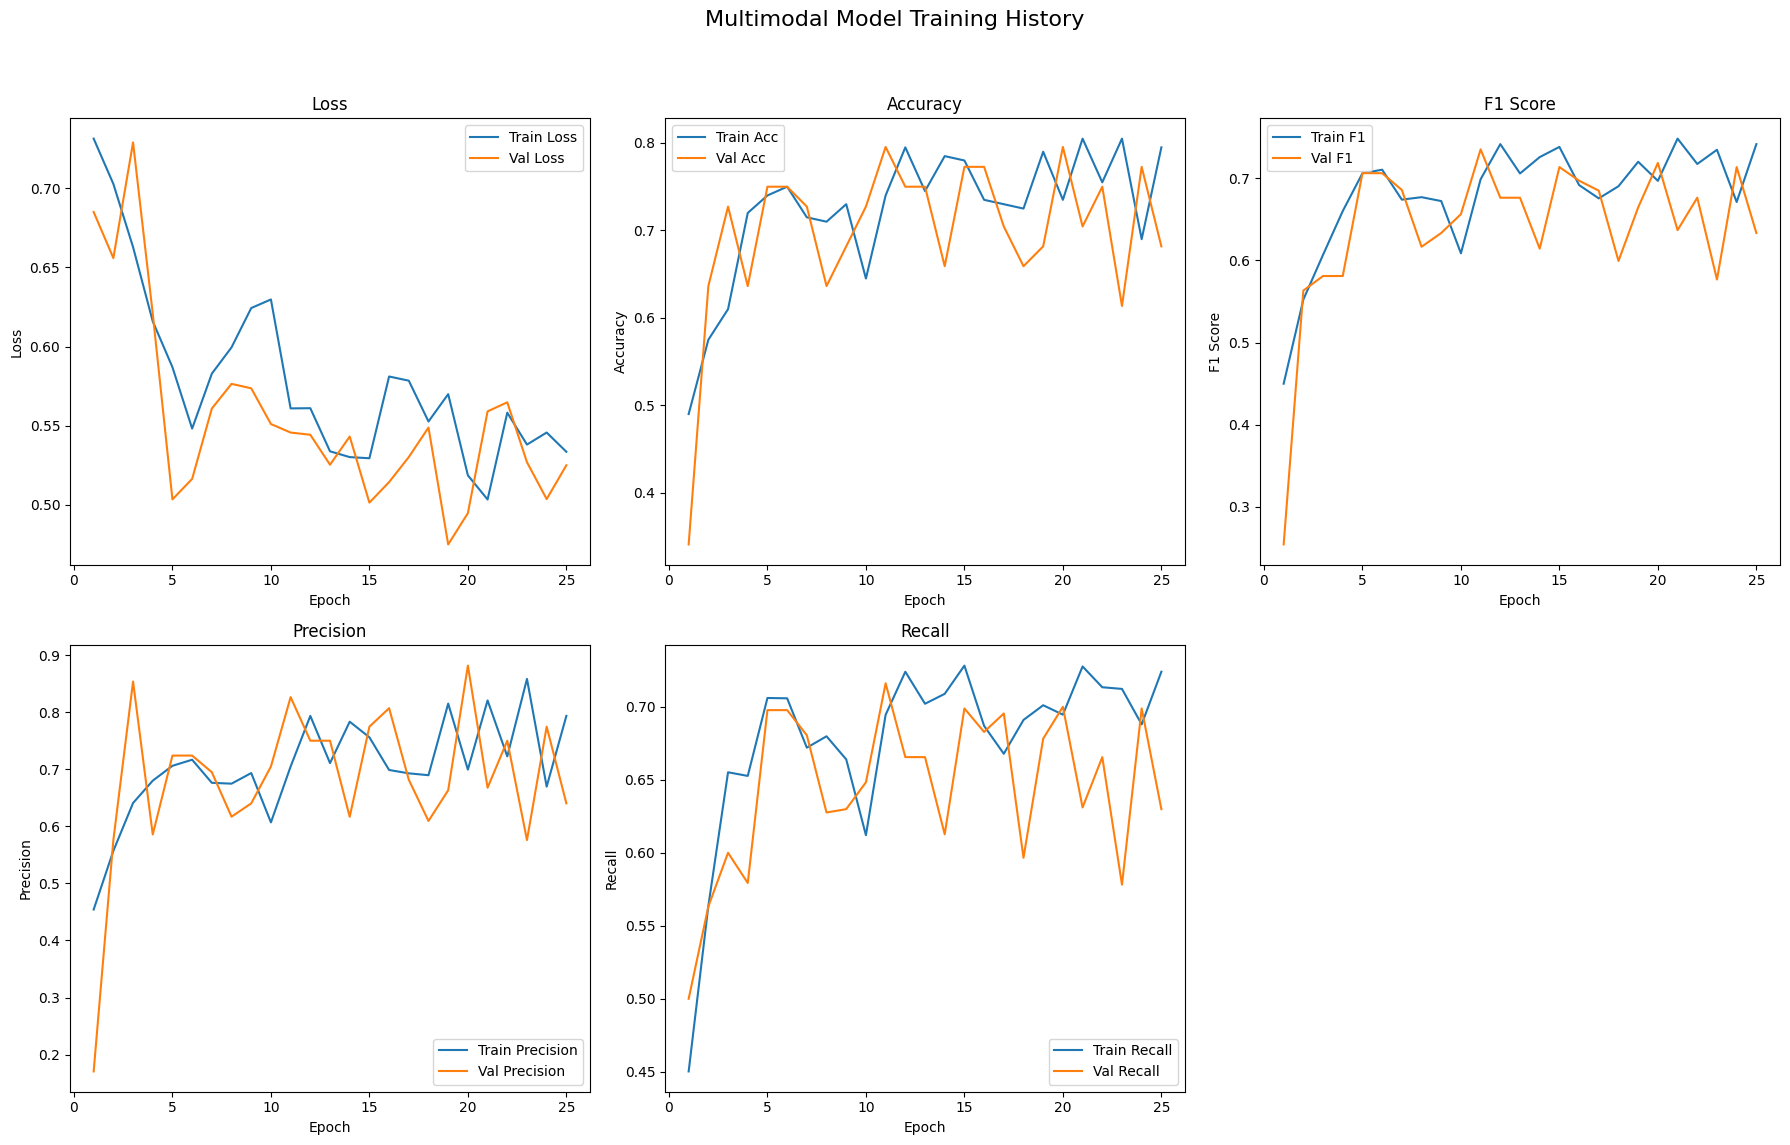

In [13]:
# Train multimodal model
history_multimodal = train_model(
    model=multimodal_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_multimodal,
    num_epochs=num_epochs,
    device='cpu',
    model_type='multimodal'
)

plot_training_history(history_multimodal, title="Multimodal Model Training History")


Epoch 1/25
----------


Train Epoch 1/25: 100%|██████████| 13/13 [01:12<00:00,  5.58s/it, loss=0.863, acc=0.53] 


Train Loss: 0.7760 Acc: 0.5300
Train F1: 0.5143 Precision: 0.5266 Recall: 0.5301


Val Epoch 1/25: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it, loss=0.604, acc=0.659]


Val Loss: 0.6101 Acc: 0.6591
Val F1: 0.6589 Precision: 0.7188 Recall: 0.7253
Epoch 2/25
----------


Train Epoch 2/25: 100%|██████████| 13/13 [01:13<00:00,  5.67s/it, loss=0.718, acc=0.7]  


Train Loss: 0.6280 Acc: 0.7000
Train F1: 0.6633 Precision: 0.6622 Recall: 0.6646


Val Epoch 2/25: 100%|██████████| 3/3 [00:06<00:00,  2.14s/it, loss=0.705, acc=0.659]


Val Loss: 0.8135 Acc: 0.6591
Val F1: 0.4532 Precision: 0.5833 Recall: 0.5161
Epoch 3/25
----------


Train Epoch 3/25: 100%|██████████| 13/13 [01:12<00:00,  5.56s/it, loss=0.884, acc=0.635]


Train Loss: 0.6603 Acc: 0.6350
Train F1: 0.6206 Precision: 0.6268 Recall: 0.6430


Val Epoch 3/25: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it, loss=0.699, acc=0.523]


Val Loss: 0.6754 Acc: 0.5227
Val F1: 0.5225 Precision: 0.5929 Recall: 0.5897
Epoch 4/25
----------


Train Epoch 4/25: 100%|██████████| 13/13 [01:13<00:00,  5.66s/it, loss=0.424, acc=0.71] 


Train Loss: 0.5495 Acc: 0.7100
Train F1: 0.6769 Precision: 0.6747 Recall: 0.6798


Val Epoch 4/25: 100%|██████████| 3/3 [00:06<00:00,  2.31s/it, loss=0.486, acc=0.773]


Val Loss: 0.4967 Acc: 0.7727
Val F1: 0.7135 Precision: 0.7746 Recall: 0.6989
Epoch 5/25
----------


Train Epoch 5/25: 100%|██████████| 13/13 [01:12<00:00,  5.57s/it, loss=0.663, acc=0.7]  


Train Loss: 0.6515 Acc: 0.7000
Train F1: 0.6633 Precision: 0.6622 Recall: 0.6646


Val Epoch 5/25: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it, loss=0.576, acc=0.75] 


Val Loss: 0.5393 Acc: 0.7500
Val F1: 0.7171 Precision: 0.7214 Recall: 0.7138
Epoch 6/25
----------


Train Epoch 6/25: 100%|██████████| 13/13 [01:12<00:00,  5.59s/it, loss=0.633, acc=0.72] 


Train Loss: 0.5834 Acc: 0.7200
Train F1: 0.6858 Precision: 0.6845 Recall: 0.6872


Val Epoch 6/25: 100%|██████████| 3/3 [00:06<00:00,  2.14s/it, loss=0.53, acc=0.727] 


Val Loss: 0.5733 Acc: 0.7273
Val F1: 0.6562 Precision: 0.7048 Recall: 0.6483
Epoch 7/25
----------


Train Epoch 7/25: 100%|██████████| 13/13 [01:13<00:00,  5.68s/it, loss=0.516, acc=0.74] 


Train Loss: 0.5581 Acc: 0.7400
Train F1: 0.7013 Precision: 0.7050 Recall: 0.6983


Val Epoch 7/25: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it, loss=0.611, acc=0.727]


Val Loss: 0.5098 Acc: 0.7273
Val F1: 0.6725 Precision: 0.6970 Recall: 0.6644
Epoch 8/25
----------


Train Epoch 8/25: 100%|██████████| 13/13 [01:29<00:00,  6.85s/it, loss=0.383, acc=0.79] 


Train Loss: 0.5692 Acc: 0.7900
Train F1: 0.7500 Precision: 0.7686 Recall: 0.7395


Val Epoch 8/25: 100%|██████████| 3/3 [00:06<00:00,  2.16s/it, loss=0.788, acc=0.568]


Val Loss: 0.6359 Acc: 0.5682
Val F1: 0.5680 Precision: 0.6452 Recall: 0.6402
Epoch 9/25
----------


Train Epoch 9/25: 100%|██████████| 13/13 [01:11<00:00,  5.50s/it, loss=0.661, acc=0.69] 


Train Loss: 0.5733 Acc: 0.6900
Train F1: 0.6675 Precision: 0.6647 Recall: 0.6802


Val Epoch 9/25: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it, loss=0.6, acc=0.795]  


Val Loss: 0.5559 Acc: 0.7955
Val F1: 0.7186 Precision: 0.8816 Recall: 0.7000
Epoch 10/25
----------


Train Epoch 10/25: 100%|██████████| 13/13 [01:13<00:00,  5.68s/it, loss=0.258, acc=0.76] 


Train Loss: 0.5695 Acc: 0.7600
Train F1: 0.7056 Precision: 0.7352 Recall: 0.6940


Val Epoch 10/25: 100%|██████████| 3/3 [00:06<00:00,  2.27s/it, loss=0.528, acc=0.727]


Val Loss: 0.5035 Acc: 0.7273
Val F1: 0.6725 Precision: 0.6970 Recall: 0.6644
Epoch 11/25
----------


Train Epoch 11/25: 100%|██████████| 13/13 [01:15<00:00,  5.81s/it, loss=0.472, acc=0.78] 


Train Loss: 0.5376 Acc: 0.7800
Train F1: 0.7472 Precision: 0.7518 Recall: 0.7436


Val Epoch 11/25: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it, loss=0.769, acc=0.568]


Val Loss: 0.6211 Acc: 0.5682
Val F1: 0.5625 Precision: 0.5833 Recall: 0.5920
Epoch 12/25
----------


Train Epoch 12/25: 100%|██████████| 13/13 [01:13<00:00,  5.66s/it, loss=1.05, acc=0.74]  


Train Loss: 0.5462 Acc: 0.7400
Train F1: 0.6988 Precision: 0.7048 Recall: 0.6945


Val Epoch 12/25: 100%|██████████| 3/3 [00:06<00:00,  2.19s/it, loss=0.545, acc=0.75] 


Val Loss: 0.5816 Acc: 0.7500
Val F1: 0.6763 Precision: 0.7500 Recall: 0.6655
Epoch 13/25
----------


Train Epoch 13/25: 100%|██████████| 13/13 [01:13<00:00,  5.66s/it, loss=0.47, acc=0.78]  


Train Loss: 0.5494 Acc: 0.7800
Train F1: 0.7381 Precision: 0.7560 Recall: 0.7282


Val Epoch 13/25: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it, loss=0.592, acc=0.682]


Val Loss: 0.5558 Acc: 0.6818
Val F1: 0.6179 Precision: 0.6364 Recall: 0.6138
Epoch 14/25
----------


Train Epoch 14/25: 100%|██████████| 13/13 [01:13<00:00,  5.68s/it, loss=0.66, acc=0.765] 


Train Loss: 0.5688 Acc: 0.7650
Train F1: 0.7102 Precision: 0.7432 Recall: 0.6978


Val Epoch 14/25: 100%|██████████| 3/3 [00:06<00:00,  2.16s/it, loss=0.528, acc=0.75] 


Val Loss: 0.5553 Acc: 0.7500
Val F1: 0.6763 Precision: 0.7500 Recall: 0.6655
Epoch 15/25
----------


Train Epoch 15/25: 100%|██████████| 13/13 [01:14<00:00,  5.72s/it, loss=0.503, acc=0.77] 


Train Loss: 0.5680 Acc: 0.7700
Train F1: 0.7083 Precision: 0.7583 Recall: 0.6938


Val Epoch 15/25: 100%|██████████| 3/3 [00:06<00:00,  2.16s/it, loss=0.537, acc=0.614]


Val Loss: 0.5780 Acc: 0.6136
Val F1: 0.5628 Precision: 0.5643 Recall: 0.5621
Epoch 16/25
----------


Train Epoch 16/25: 100%|██████████| 13/13 [01:14<00:00,  5.74s/it, loss=0.604, acc=0.67] 


Train Loss: 0.5568 Acc: 0.6700
Train F1: 0.6532 Precision: 0.6545 Recall: 0.6730


Val Epoch 16/25: 100%|██████████| 3/3 [00:06<00:00,  2.21s/it, loss=0.479, acc=0.773]


Val Loss: 0.5633 Acc: 0.7727
Val F1: 0.6970 Precision: 0.8069 Recall: 0.6828
Epoch 17/25
----------


Train Epoch 17/25: 100%|██████████| 13/13 [01:14<00:00,  5.71s/it, loss=0.425, acc=0.78] 


Train Loss: 0.5955 Acc: 0.7800
Train F1: 0.7176 Precision: 0.7781 Recall: 0.7013


Val Epoch 17/25: 100%|██████████| 3/3 [00:06<00:00,  2.16s/it, loss=0.64, acc=0.659] 


Val Loss: 0.5940 Acc: 0.6591
Val F1: 0.5993 Precision: 0.6094 Recall: 0.5966
Epoch 18/25
----------


Train Epoch 18/25: 100%|██████████| 13/13 [01:12<00:00,  5.59s/it, loss=0.526, acc=0.7]  


Train Loss: 0.5798 Acc: 0.7000
Train F1: 0.6725 Precision: 0.6689 Recall: 0.6800


Val Epoch 18/25: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it, loss=0.508, acc=0.795]


Val Loss: 0.5145 Acc: 0.7955
Val F1: 0.7351 Precision: 0.8264 Recall: 0.7161
Epoch 19/25
----------


Train Epoch 19/25: 100%|██████████| 13/13 [01:13<00:00,  5.67s/it, loss=0.525, acc=0.79] 


Train Loss: 0.5013 Acc: 0.7900
Train F1: 0.7367 Precision: 0.7838 Recall: 0.7203


Val Epoch 19/25: 100%|██████████| 3/3 [00:06<00:00,  2.18s/it, loss=0.541, acc=0.773]


Val Loss: 0.5263 Acc: 0.7727
Val F1: 0.7135 Precision: 0.7746 Recall: 0.6989
Epoch 20/25
----------


Train Epoch 20/25: 100%|██████████| 13/13 [01:14<00:00,  5.71s/it, loss=0.664, acc=0.775]


Train Loss: 0.5180 Acc: 0.7750
Train F1: 0.7254 Precision: 0.7545 Recall: 0.7129


Val Epoch 20/25: 100%|██████████| 3/3 [00:06<00:00,  2.21s/it, loss=0.619, acc=0.705]


Val Loss: 0.5102 Acc: 0.7045
Val F1: 0.6527 Precision: 0.6667 Recall: 0.6471
Epoch 21/25
----------


Train Epoch 21/25: 100%|██████████| 13/13 [01:12<00:00,  5.57s/it, loss=1.14, acc=0.77]  


Train Loss: 0.5203 Acc: 0.7700
Train F1: 0.7312 Precision: 0.7411 Recall: 0.7246


Val Epoch 21/25: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it, loss=0.612, acc=0.659]


Val Loss: 0.5306 Acc: 0.6591
Val F1: 0.6143 Precision: 0.6167 Recall: 0.6126
Epoch 22/25
----------


Train Epoch 22/25: 100%|██████████| 13/13 [01:15<00:00,  5.84s/it, loss=0.485, acc=0.79] 


Train Loss: 0.5463 Acc: 0.7900
Train F1: 0.7396 Precision: 0.7798 Recall: 0.7241


Val Epoch 22/25: 100%|██████████| 3/3 [00:06<00:00,  2.22s/it, loss=0.512, acc=0.705]


Val Loss: 0.5125 Acc: 0.7045
Val F1: 0.6527 Precision: 0.6667 Recall: 0.6471
Epoch 23/25
----------


Train Epoch 23/25: 100%|██████████| 13/13 [01:14<00:00,  5.76s/it, loss=0.911, acc=0.725]


Train Loss: 0.5354 Acc: 0.7250
Train F1: 0.6925 Precision: 0.6906 Recall: 0.6948


Val Epoch 23/25: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it, loss=0.459, acc=0.75] 


Val Loss: 0.4790 Acc: 0.7500
Val F1: 0.7061 Precision: 0.7240 Recall: 0.6977
Epoch 24/25
----------


Train Epoch 24/25: 100%|██████████| 13/13 [01:14<00:00,  5.73s/it, loss=0.433, acc=0.79] 


Train Loss: 0.5184 Acc: 0.7900
Train F1: 0.7424 Precision: 0.7763 Recall: 0.7280


Val Epoch 24/25: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it, loss=0.485, acc=0.75] 


Val Loss: 0.5253 Acc: 0.7500
Val F1: 0.6763 Precision: 0.7500 Recall: 0.6655
Epoch 25/25
----------


Train Epoch 25/25: 100%|██████████| 13/13 [01:14<00:00,  5.74s/it, loss=0.711, acc=0.75] 


Train Loss: 0.5315 Acc: 0.7500
Train F1: 0.7078 Precision: 0.7169 Recall: 0.7019


Val Epoch 25/25: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it, loss=0.489, acc=0.727]


Val Loss: 0.5228 Acc: 0.7273
Val F1: 0.6562 Precision: 0.7048 Recall: 0.6483
Best Validation F1: 0.7351


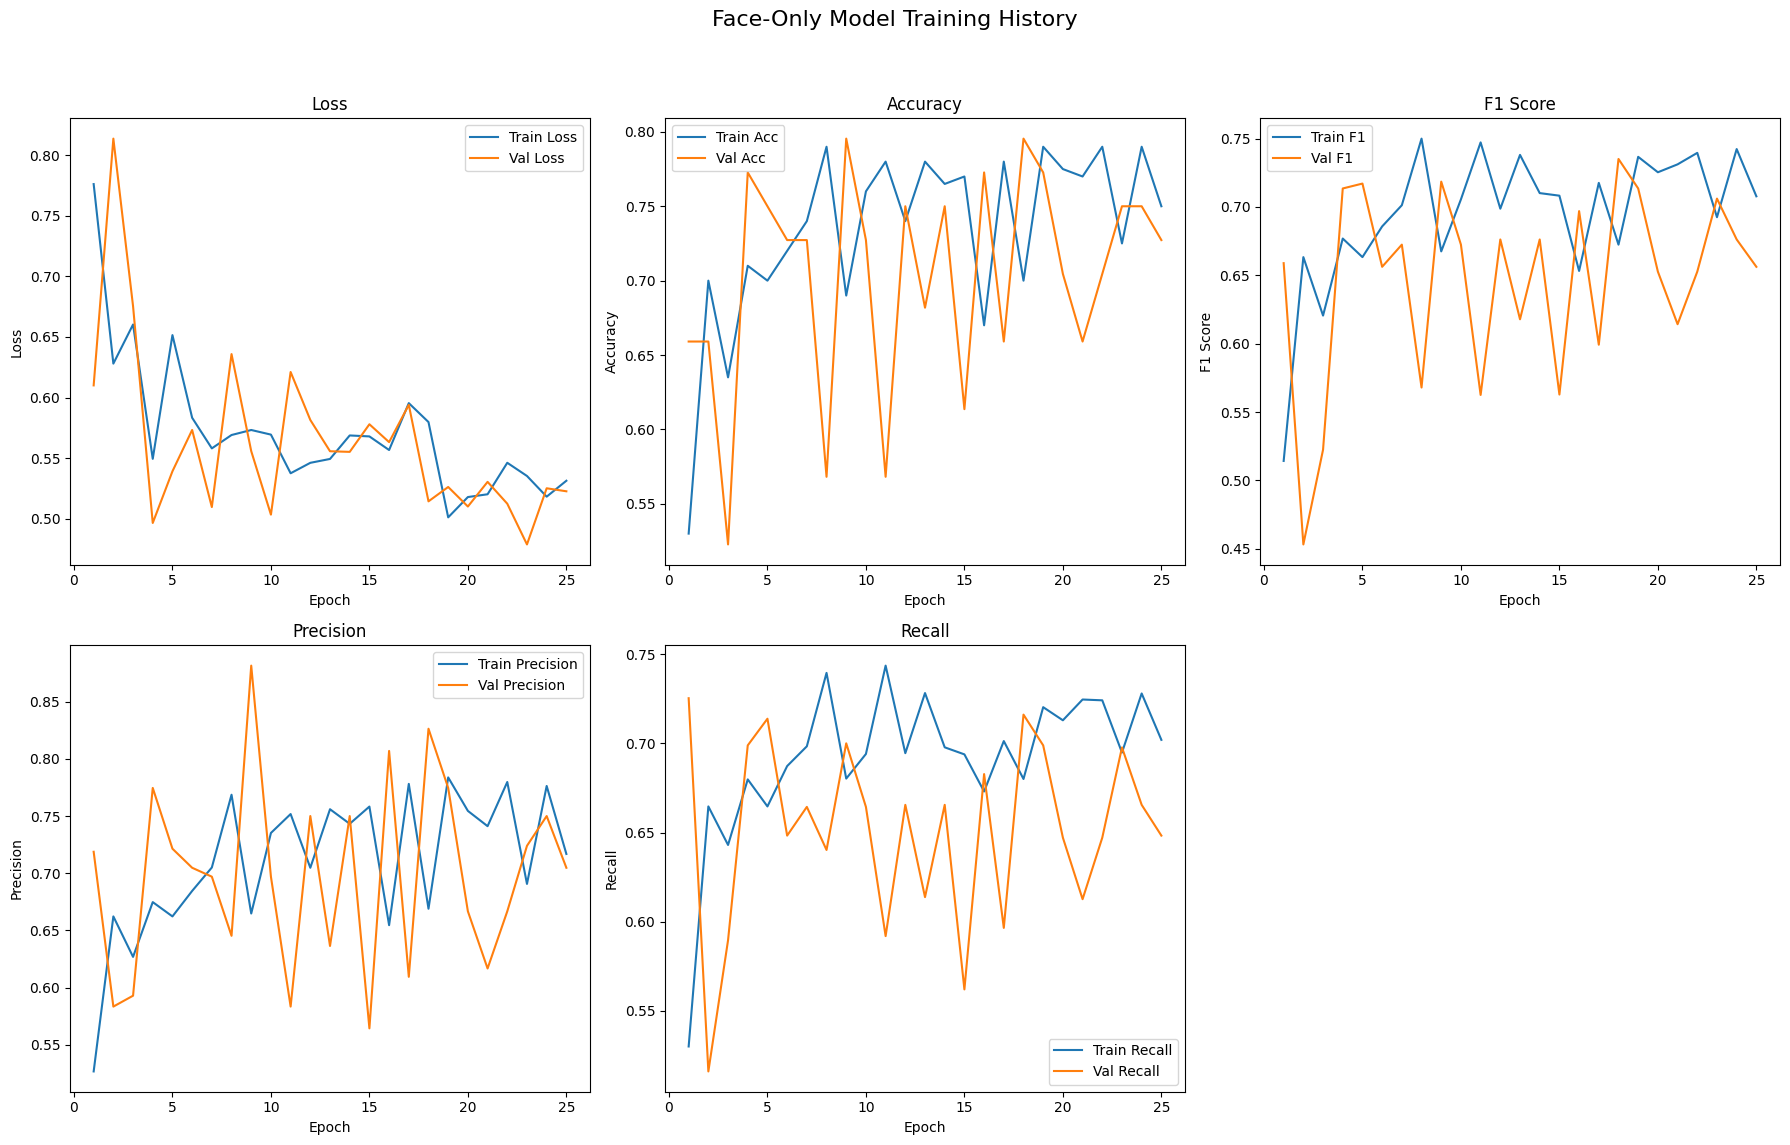

Epoch 1/25
----------


Train Epoch 1/25: 100%|██████████| 13/13 [03:28<00:00, 16.04s/it, loss=0.771, acc=0.46] 


Train Loss: 0.7377 Acc: 0.4600
Train F1: 0.4565 Precision: 0.4903 Recall: 0.4894


Val Epoch 1/25: 100%|██████████| 3/3 [00:15<00:00,  5.16s/it, loss=0.699, acc=0.341]


Val Loss: 0.6945 Acc: 0.3409
Val F1: 0.2542 Precision: 0.1705 Recall: 0.5000
Epoch 2/25
----------


Train Epoch 2/25: 100%|██████████| 13/13 [03:30<00:00, 16.19s/it, loss=0.686, acc=0.65] 


Train Loss: 0.6932 Acc: 0.6500
Train F1: 0.4816 Precision: 0.5389 Recall: 0.5158


Val Epoch 2/25: 100%|██████████| 3/3 [00:15<00:00,  5.06s/it, loss=0.687, acc=0.659]


Val Loss: 0.7018 Acc: 0.6591
Val F1: 0.3973 Precision: 0.3295 Recall: 0.5000
Epoch 3/25
----------


Train Epoch 3/25: 100%|██████████| 13/13 [03:28<00:00, 16.07s/it, loss=0.727, acc=0.67] 


Train Loss: 0.6946 Acc: 0.6700
Train F1: 0.4012 Precision: 0.3350 Recall: 0.5000


Val Epoch 3/25: 100%|██████████| 3/3 [00:14<00:00,  4.99s/it, loss=0.683, acc=0.659]


Val Loss: 0.7015 Acc: 0.6591
Val F1: 0.3973 Precision: 0.3295 Recall: 0.5000
Epoch 4/25
----------


Train Epoch 4/25: 100%|██████████| 13/13 [03:30<00:00, 16.16s/it, loss=0.693, acc=0.545]


Train Loss: 0.6951 Acc: 0.5450
Train F1: 0.4447 Precision: 0.4436 Recall: 0.4528


Val Epoch 4/25: 100%|██████████| 3/3 [00:15<00:00,  5.06s/it, loss=0.692, acc=0.659]


Val Loss: 0.6947 Acc: 0.6591
Val F1: 0.3973 Precision: 0.3295 Recall: 0.5000
Epoch 5/25
----------


Train Epoch 5/25: 100%|██████████| 13/13 [03:32<00:00, 16.31s/it, loss=0.727, acc=0.665]


Train Loss: 0.6915 Acc: 0.6650
Train F1: 0.4386 Precision: 0.5511 Recall: 0.5078


Val Epoch 5/25: 100%|██████████| 3/3 [00:15<00:00,  5.04s/it, loss=0.676, acc=0.659]


Val Loss: 0.6952 Acc: 0.6591
Val F1: 0.3973 Precision: 0.3295 Recall: 0.5000
Epoch 6/25
----------


Train Epoch 6/25: 100%|██████████| 13/13 [03:29<00:00, 16.13s/it, loss=0.694, acc=0.67] 


Train Loss: 0.6911 Acc: 0.6700
Train F1: 0.4012 Precision: 0.3350 Recall: 0.5000


Val Epoch 6/25: 100%|██████████| 3/3 [00:15<00:00,  5.07s/it, loss=0.687, acc=0.659]


Val Loss: 0.6984 Acc: 0.6591
Val F1: 0.3973 Precision: 0.3295 Recall: 0.5000
Epoch 7/25
----------


Train Epoch 7/25: 100%|██████████| 13/13 [03:31<00:00, 16.28s/it, loss=0.708, acc=0.65] 


Train Loss: 0.6883 Acc: 0.6500
Train F1: 0.4531 Precision: 0.5146 Recall: 0.5043


Val Epoch 7/25: 100%|██████████| 3/3 [00:15<00:00,  5.08s/it, loss=0.668, acc=0.614]


Val Loss: 0.6999 Acc: 0.6136
Val F1: 0.3803 Precision: 0.3214 Recall: 0.4655
Epoch 8/25
----------


Train Epoch 8/25: 100%|██████████| 13/13 [03:30<00:00, 16.17s/it, loss=0.658, acc=0.625]


Train Loss: 0.6919 Acc: 0.6250
Train F1: 0.5271 Precision: 0.5416 Recall: 0.5318


Val Epoch 8/25: 100%|██████████| 3/3 [00:15<00:00,  5.06s/it, loss=0.698, acc=0.386]


Val Loss: 0.7036 Acc: 0.3864
Val F1: 0.3835 Precision: 0.4479 Recall: 0.4540
Epoch 9/25
----------


Train Epoch 9/25: 100%|██████████| 13/13 [03:37<00:00, 16.74s/it, loss=0.601, acc=0.515]


Train Loss: 0.6851 Acc: 0.5150
Train F1: 0.5147 Precision: 0.5702 Recall: 0.5727


Val Epoch 9/25: 100%|██████████| 3/3 [00:15<00:00,  5.13s/it, loss=0.665, acc=0.591]


Val Loss: 0.7468 Acc: 0.5909
Val F1: 0.3714 Precision: 0.3171 Recall: 0.4483
Epoch 10/25
----------


Train Epoch 10/25: 100%|██████████| 13/13 [03:31<00:00, 16.27s/it, loss=0.757, acc=0.575]


Train Loss: 0.6980 Acc: 0.5750
Train F1: 0.5213 Precision: 0.5212 Recall: 0.5214


Val Epoch 10/25: 100%|██████████| 3/3 [00:15<00:00,  5.32s/it, loss=0.695, acc=0.5]  


Val Loss: 0.7267 Acc: 0.5000
Val F1: 0.3995 Precision: 0.3939 Recall: 0.4115
Epoch 11/25
----------


Train Epoch 11/25: 100%|██████████| 13/13 [03:43<00:00, 17.20s/it, loss=0.708, acc=0.63] 


Train Loss: 0.6922 Acc: 0.6300
Train F1: 0.4519 Precision: 0.4833 Recall: 0.4932


Val Epoch 11/25: 100%|██████████| 3/3 [00:15<00:00,  5.04s/it, loss=0.692, acc=0.545]


Val Loss: 0.6993 Acc: 0.5455
Val F1: 0.3529 Precision: 0.3077 Recall: 0.4138
Epoch 12/25
----------


Train Epoch 12/25: 100%|██████████| 13/13 [03:32<00:00, 16.32s/it, loss=0.683, acc=0.68] 


Train Loss: 0.6893 Acc: 0.6800
Train F1: 0.5987 Precision: 0.6235 Recall: 0.5959


Val Epoch 12/25: 100%|██████████| 3/3 [00:15<00:00,  5.06s/it, loss=0.684, acc=0.432]


Val Loss: 0.7139 Acc: 0.4318
Val F1: 0.3016 Precision: 0.2794 Recall: 0.3276
Epoch 13/25
----------


Train Epoch 13/25: 100%|██████████| 13/13 [03:44<00:00, 17.30s/it, loss=0.694, acc=0.495]


Train Loss: 0.6962 Acc: 0.4950
Train F1: 0.4809 Precision: 0.4967 Recall: 0.4963


Val Epoch 13/25: 100%|██████████| 3/3 [00:15<00:00,  5.30s/it, loss=0.7, acc=0.386]  


Val Loss: 0.7101 Acc: 0.3864
Val F1: 0.3057 Precision: 0.3024 Recall: 0.3092
Epoch 14/25
----------


Train Epoch 14/25: 100%|██████████| 13/13 [03:29<00:00, 16.15s/it, loss=0.683, acc=0.59] 


Train Loss: 0.6864 Acc: 0.5900
Train F1: 0.5432 Precision: 0.5429 Recall: 0.5441


Val Epoch 14/25: 100%|██████████| 3/3 [00:15<00:00,  5.30s/it, loss=0.697, acc=0.364]


Val Loss: 0.7183 Acc: 0.3636
Val F1: 0.3125 Precision: 0.3181 Recall: 0.3080
Epoch 15/25
----------


Train Epoch 15/25: 100%|██████████| 13/13 [03:29<00:00, 16.08s/it, loss=0.597, acc=0.6]  


Train Loss: 0.6871 Acc: 0.6000
Train F1: 0.5575 Precision: 0.5569 Recall: 0.5592


Val Epoch 15/25: 100%|██████████| 3/3 [00:15<00:00,  5.29s/it, loss=0.792, acc=0.386]


Val Loss: 0.7697 Acc: 0.3864
Val F1: 0.3783 Precision: 0.4618 Recall: 0.4701
Epoch 16/25
----------


Train Epoch 16/25: 100%|██████████| 13/13 [03:29<00:00, 16.15s/it, loss=0.748, acc=0.53] 


Train Loss: 0.7070 Acc: 0.5300
Train F1: 0.5177 Precision: 0.5334 Recall: 0.5378


Val Epoch 16/25: 100%|██████████| 3/3 [00:16<00:00,  5.34s/it, loss=0.764, acc=0.341]


Val Loss: 0.7421 Acc: 0.3409
Val F1: 0.3238 Precision: 0.4028 Recall: 0.4356
Epoch 17/25
----------


Train Epoch 17/25: 100%|██████████| 13/13 [03:30<00:00, 16.18s/it, loss=0.66, acc=0.5]   


Train Loss: 0.6954 Acc: 0.5000
Train F1: 0.4885 Precision: 0.5068 Recall: 0.5077


Val Epoch 17/25: 100%|██████████| 3/3 [00:16<00:00,  5.35s/it, loss=0.692, acc=0.386]


Val Loss: 0.7051 Acc: 0.3864
Val F1: 0.3835 Precision: 0.4124 Recall: 0.4057
Epoch 18/25
----------


Train Epoch 18/25: 100%|██████████| 13/13 [03:30<00:00, 16.16s/it, loss=0.714, acc=0.51] 


Train Loss: 0.6878 Acc: 0.5100
Train F1: 0.5060 Precision: 0.5382 Recall: 0.5421


Val Epoch 18/25: 100%|██████████| 3/3 [00:15<00:00,  5.27s/it, loss=0.685, acc=0.523]


Val Loss: 0.7100 Acc: 0.5227
Val F1: 0.4771 Precision: 0.4777 Recall: 0.4770
Epoch 19/25
----------


Train Epoch 19/25: 100%|██████████| 13/13 [03:34<00:00, 16.49s/it, loss=0.803, acc=0.63] 


Train Loss: 0.6854 Acc: 0.6300
Train F1: 0.5749 Precision: 0.5764 Recall: 0.5739


Val Epoch 19/25: 100%|██████████| 3/3 [00:15<00:00,  5.33s/it, loss=0.725, acc=0.432]


Val Loss: 0.7601 Acc: 0.4318
Val F1: 0.3571 Precision: 0.3548 Recall: 0.3598
Epoch 20/25
----------


Train Epoch 20/25: 100%|██████████| 13/13 [03:30<00:00, 16.20s/it, loss=0.716, acc=0.545]


Train Loss: 0.6785 Acc: 0.5450
Train F1: 0.5424 Precision: 0.5802 Recall: 0.5874


Val Epoch 20/25: 100%|██████████| 3/3 [00:15<00:00,  5.19s/it, loss=0.696, acc=0.568]


Val Loss: 0.7314 Acc: 0.5682
Val F1: 0.4408 Precision: 0.4444 Recall: 0.4632
Epoch 21/25
----------


Train Epoch 21/25: 100%|██████████| 13/13 [03:30<00:00, 16.22s/it, loss=0.672, acc=0.62] 


Train Loss: 0.6784 Acc: 0.6200
Train F1: 0.5338 Precision: 0.5433 Recall: 0.5357


Val Epoch 21/25: 100%|██████████| 3/3 [00:15<00:00,  5.07s/it, loss=0.737, acc=0.455]


Val Loss: 0.7701 Acc: 0.4545
Val F1: 0.3931 Precision: 0.3931 Recall: 0.3931
Epoch 22/25
----------


Train Epoch 22/25: 100%|██████████| 13/13 [03:31<00:00, 16.25s/it, loss=0.829, acc=0.63] 


Train Loss: 0.6772 Acc: 0.6300
Train F1: 0.6032 Precision: 0.6027 Recall: 0.6124


Val Epoch 22/25: 100%|██████████| 3/3 [00:15<00:00,  5.10s/it, loss=0.703, acc=0.5]  


Val Loss: 0.7248 Acc: 0.5000
Val F1: 0.3995 Precision: 0.3939 Recall: 0.4115
Epoch 23/25
----------


Train Epoch 23/25: 100%|██████████| 13/13 [03:31<00:00, 16.29s/it, loss=0.703, acc=0.67] 


Train Loss: 0.6890 Acc: 0.6700
Train F1: 0.4411 Precision: 0.5876 Recall: 0.5115


Val Epoch 23/25: 100%|██████████| 3/3 [00:20<00:00,  6.81s/it, loss=0.694, acc=0.591]


Val Loss: 0.7033 Acc: 0.5909
Val F1: 0.3714 Precision: 0.3171 Recall: 0.4483
Epoch 24/25
----------


Train Epoch 24/25: 100%|██████████| 13/13 [03:31<00:00, 16.25s/it, loss=0.774, acc=0.525]


Train Loss: 0.6973 Acc: 0.5250
Train F1: 0.4861 Precision: 0.4888 Recall: 0.4879


Val Epoch 24/25: 100%|██████████| 3/3 [00:15<00:00,  5.10s/it, loss=0.67, acc=0.659] 


Val Loss: 0.7051 Acc: 0.6591
Val F1: 0.3973 Precision: 0.3295 Recall: 0.5000
Epoch 25/25
----------


Train Epoch 25/25: 100%|██████████| 13/13 [03:29<00:00, 16.11s/it, loss=0.693, acc=0.65] 


Train Loss: 0.6911 Acc: 0.6500
Train F1: 0.4314 Precision: 0.4842 Recall: 0.4966


Val Epoch 25/25: 100%|██████████| 3/3 [00:15<00:00,  5.02s/it, loss=0.693, acc=0.409]


Val Loss: 0.6927 Acc: 0.4091
Val F1: 0.3889 Precision: 0.5328 Recall: 0.5195
Best Validation F1: 0.4771


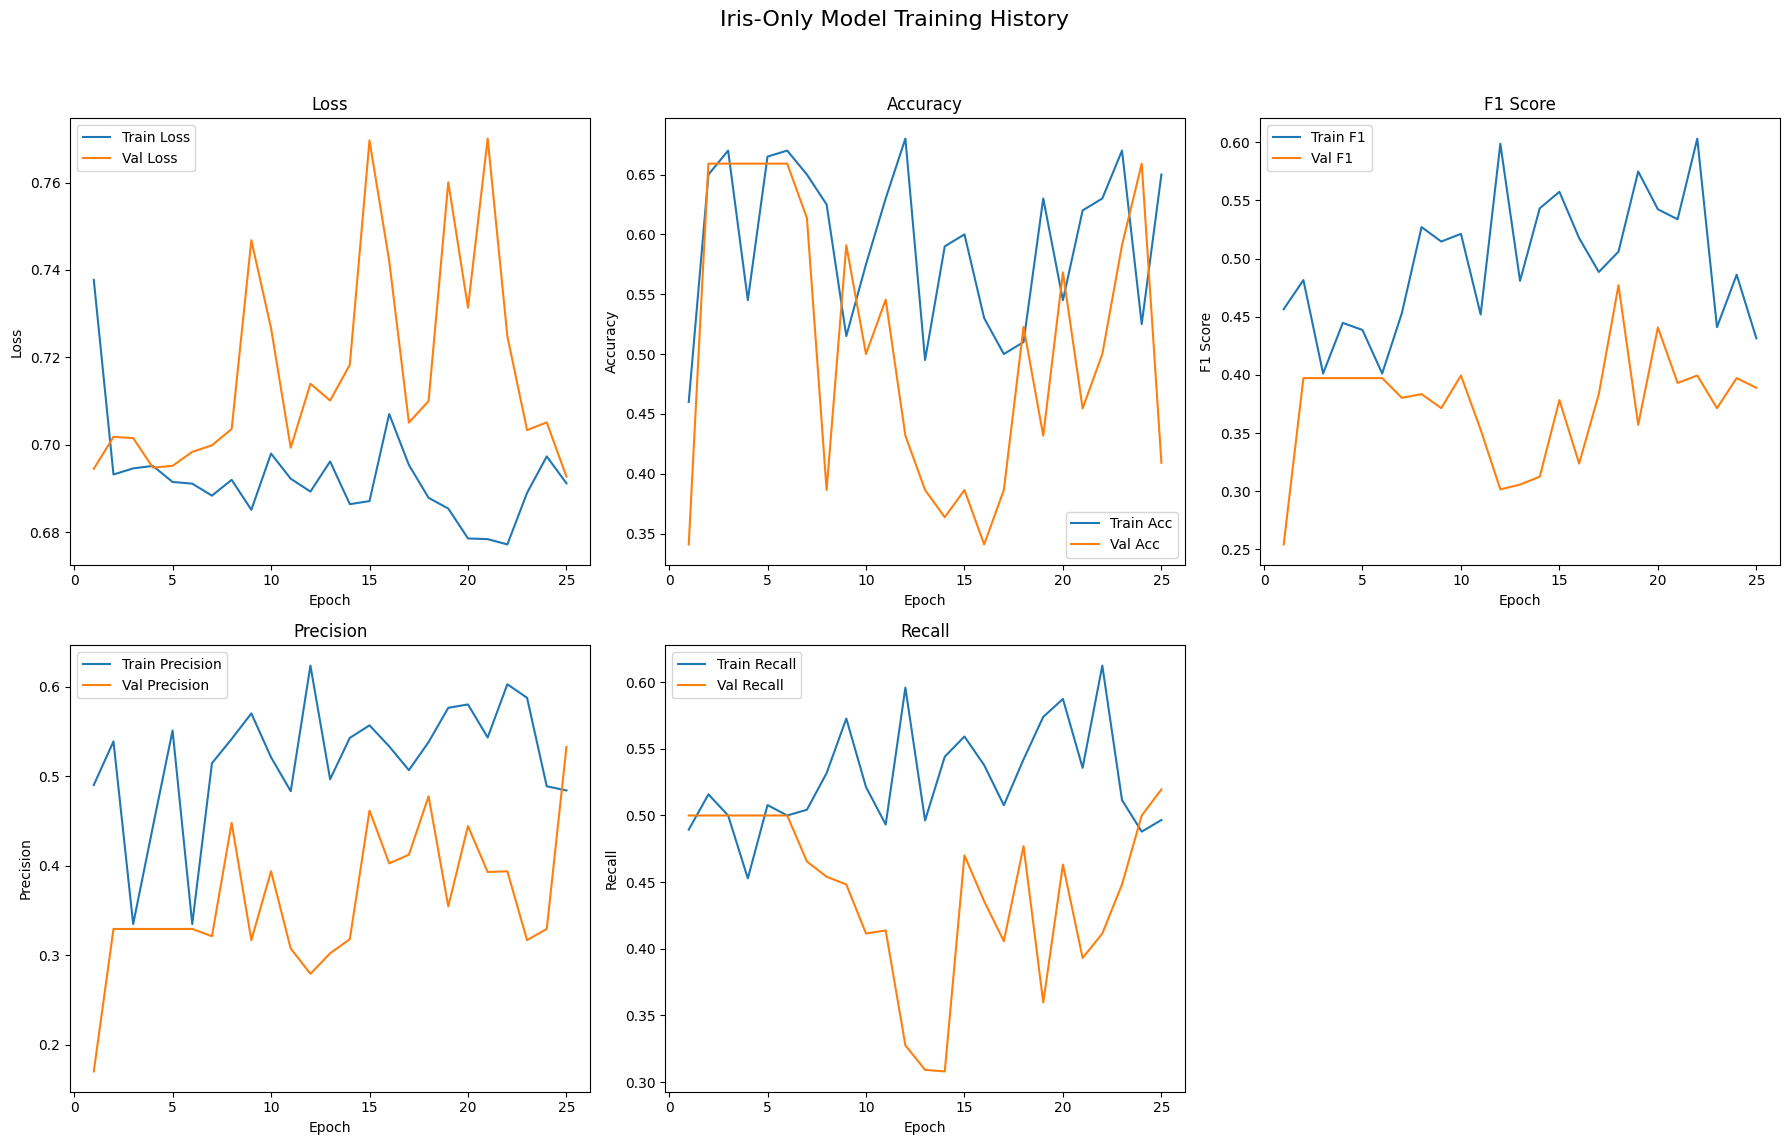

In [14]:
# Train face-only model
history_face = train_model(
    model=face_only_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_face,
    num_epochs=num_epochs,
    device='cpu',
    model_type='face_only'
)

plot_training_history(history_face, title="Face-Only Model Training History")

# Train iris-only model
history_iris = train_model(
    model=iris_only_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_iris,
    num_epochs=num_epochs,
    device='cpu',
    model_type='iris_only'
)

plot_training_history(history_iris, title="Iris-Only Model Training History")


Evaluating: 100%|██████████| 3/3 [00:20<00:00,  6.74s/it]


Test Loss: 0.6513 Acc: 0.7955
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        29
           1       1.00      0.40      0.57        15

    accuracy                           0.80        44
   macro avg       0.88      0.70      0.72        44
weighted avg       0.84      0.80      0.77        44



Evaluating: 100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


Test Loss: 0.8227 Acc: 0.7727
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        29
           1       0.86      0.40      0.55        15

    accuracy                           0.77        44
   macro avg       0.81      0.68      0.70        44
weighted avg       0.79      0.77      0.75        44



Evaluating: 100%|██████████| 3/3 [00:16<00:00,  5.59s/it]


Test Loss: 0.7030 Acc: 0.2500
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.07      0.11        29
           1       0.25      0.60      0.35        15

    accuracy                           0.25        44
   macro avg       0.25      0.33      0.23        44
weighted avg       0.25      0.25      0.19        44



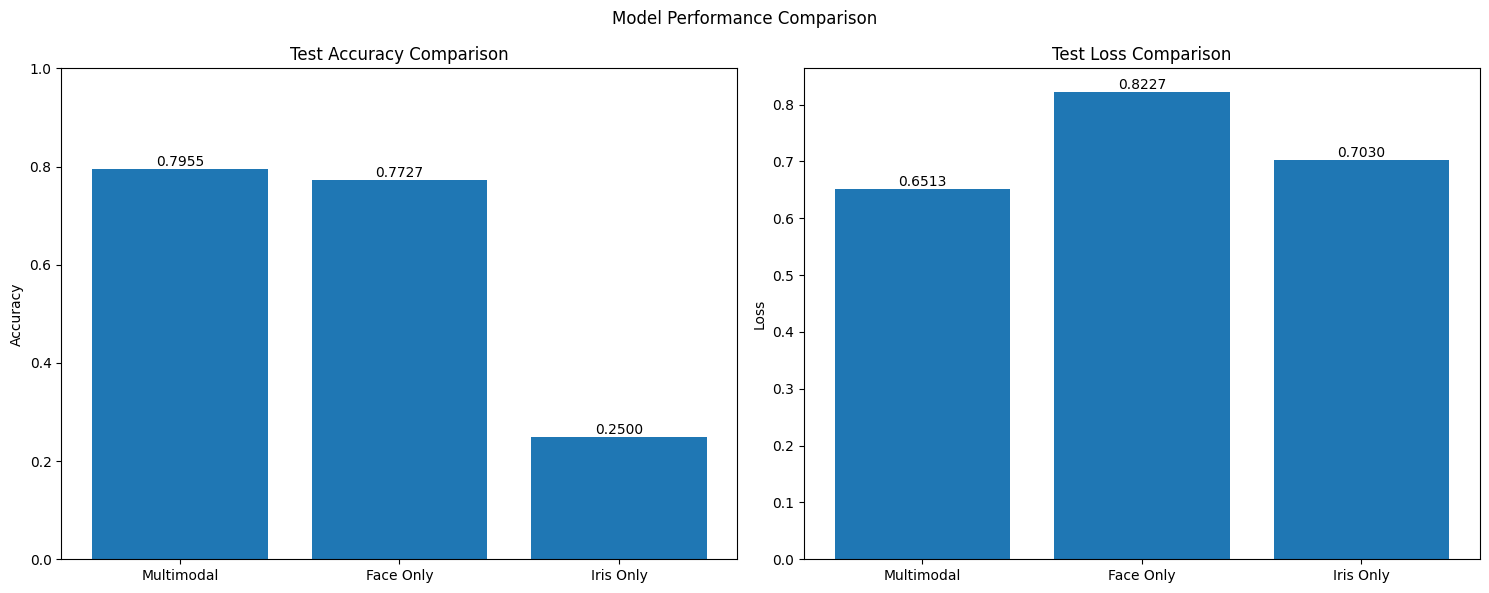

In [15]:
# Evaluate multimodal model
results_multimodal = evaluate_model(
    model=multimodal_model,
    test_loader=test_loader,
    criterion=criterion,
    device='cpu',
    model_type='multimodal'
)

# Evaluate face-only model
results_face = evaluate_model(
    model=face_only_model,
    test_loader=test_loader,
    criterion=criterion,
    device='cpu',
    model_type='face_only'
)

# Evaluate iris-only model
results_iris = evaluate_model(
    model=iris_only_model,
    test_loader=test_loader,
    criterion=criterion,
    device='cpu',
    model_type='iris_only'
)

# Compare results
results_comparison = {
    'Multimodal': results_multimodal,
    'Face Only': results_face,
    'Iris Only': results_iris
}
def compare_models(results, title='Model Performance Comparison'):
    """Compare model performance using key metrics"""
    metrics = ['accuracy', 'loss']
    models = list(results.keys())
    
    plt.figure(figsize=(15, 6))
    
    # Accuracy comparison
    plt.subplot(1, 2, 1)
    accuracies = [results[model]['accuracy'] for model in models]
    bars = plt.bar(models, accuracies)
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom')
    
    # Loss comparison
    plt.subplot(1, 2, 2)
    losses = [results[model]['loss'] for model in models]
    bars = plt.bar(models, losses)
    plt.title('Test Loss Comparison')
    plt.ylabel('Loss')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names=None, title='Confusion Matrix'):
    """Plot confusion matrix using seaborn"""
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

compare_models(results_comparison, title="Model Performance Comparison")


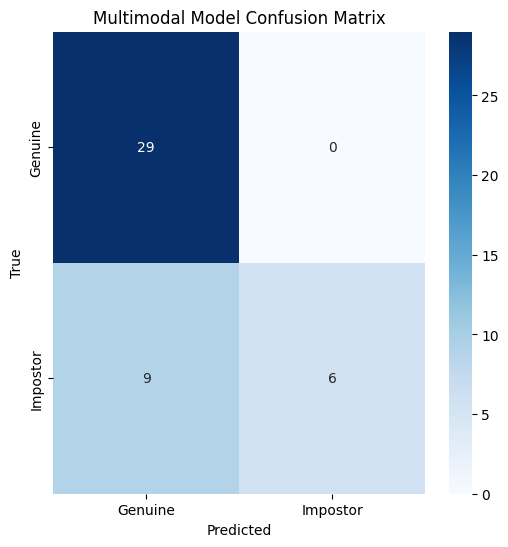

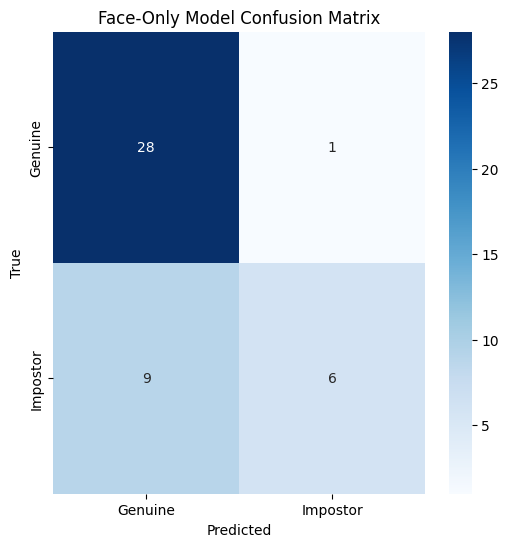

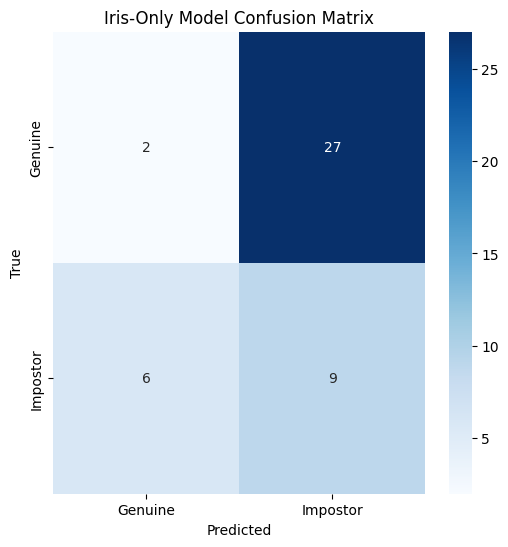

In [16]:
# Visualize confusion matrices for each model
plot_confusion_matrix(results_multimodal['confusion_matrix'], class_names=['Genuine', 'Impostor'], title="Multimodal Model Confusion Matrix")
plot_confusion_matrix(results_face['confusion_matrix'], class_names=['Genuine', 'Impostor'], title="Face-Only Model Confusion Matrix")
plot_confusion_matrix(results_iris['confusion_matrix'], class_names=['Genuine', 'Impostor'], title="Iris-Only Model Confusion Matrix")


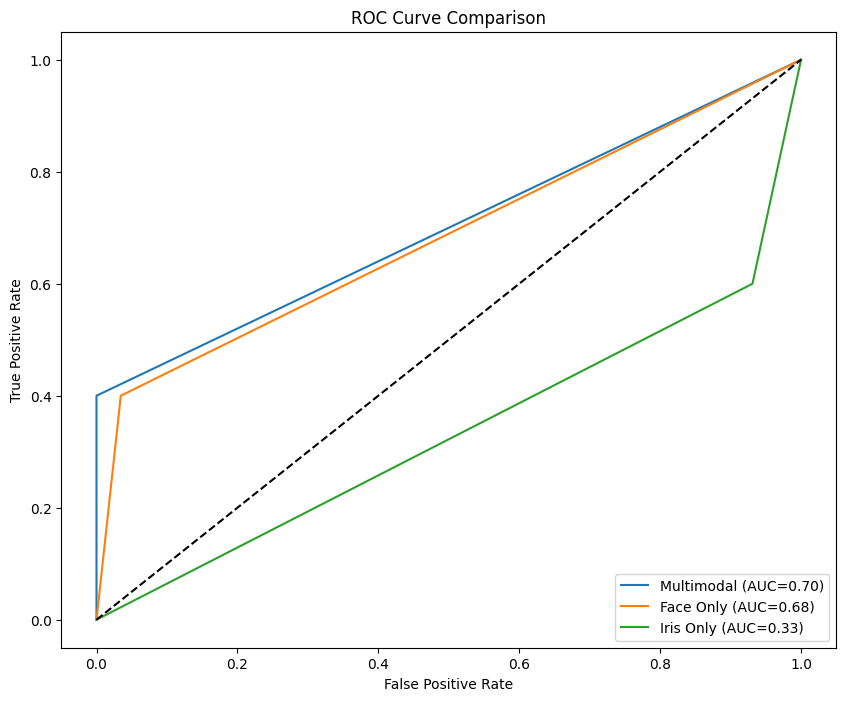

In [17]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(results, title="ROC Curve Comparison"):
    plt.figure(figsize=(10, 8))
    
    for label, result in results.items():
        fpr, tpr, _ = roc_curve(result['labels'], result['predictions'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    
plot_roc_curve(results_comparison)
